# Samokat.Tech NLP
# Цель:
Создать модель для предсказания тематик, которые затрагиваются в пользовательском ответе на опросы.
# Данные:
train.csv - файл с ID, текстом из ответа, тегами из ответа и таргетами по каждому классу.
test.csv - файл с ID, текстом и тегами из ответа.
trends_description.csv - файл с полным описанием меток класса.
# План:
- Загрузка и анализ данных
- Предобработка данных
- Исследовательский анализ
- Подбор моделей и гиперпараметров
- Обучение модели и анализ ошибок
- Предсказание на тестовых данных
- Заключение

## Загрузка и анализ

In [6]:
import re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import nltk
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
import emoji
import pymorphy2

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight

from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    AutoTokenizer,
    AutoModel,
    AutoConfig,
    AdamW,
    get_scheduler,
)

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import optuna

In [7]:
pd.set_option('display.max_colwidth', None)

In [8]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
train_csv = '/kaggle/input/samokat-nlp/train.csv'
test_csv = '/kaggle/input/samokat-nlp/test.csv'


In [10]:
train_data = pd.read_csv(train_csv)
test_data = pd.read_csv(test_csv)

# Первые строки тренировочного датасета
print("train_data:")
print(train_data.head())

# Тестовый датасет
print("\ntest_data:")
print(test_data.head())

train_data:
   index  assessment  \
0   5652         6.0   
1  18092         4.0   
2  13845         6.0   
3  25060         6.0   
4  15237         5.0   

                                                          tags  \
0                             {ASSORTMENT,PROMOTIONS,DELIVERY}   
1                 {ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}   
2               {DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}   
3                                {PRICE,PROMOTIONS,ASSORTMENT}   
4  {ASSORTMENT,PRODUCTS_QUALITY,PROMOTIONS,CATALOG_NAVIGATION}   

                                                                                 text  \
0  Маленький выбор товаров, хотелось бы ассортимент больше, а так вроде бы все хорошо   
1                                                                              Быстро   
2                                                    Доставка постоянно задерживается   
3                                                  Наценка и ассортимент расстраивают   
4

In [11]:
# Общая информация о тренировочном и тестовом датасетах
train_data.info()
print()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 54 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           8708 non-null   int64  
 1   assessment      8478 non-null   float64
 2   tags            8697 non-null   object 
 3   text            8708 non-null   object 
 4   trend_id_res0   8708 non-null   int64  
 5   trend_id_res1   8708 non-null   int64  
 6   trend_id_res2   8708 non-null   int64  
 7   trend_id_res3   8708 non-null   int64  
 8   trend_id_res4   8708 non-null   int64  
 9   trend_id_res5   8708 non-null   int64  
 10  trend_id_res6   8708 non-null   int64  
 11  trend_id_res7   8708 non-null   int64  
 12  trend_id_res8   8708 non-null   int64  
 13  trend_id_res9   8708 non-null   int64  
 14  trend_id_res10  8708 non-null   int64  
 15  trend_id_res11  8708 non-null   int64  
 16  trend_id_res12  8708 non-null   int64  
 17  trend_id_res13  8708 non-null   i

In [12]:
# Проверка на пропуски
print("\nПропущенные значения в train_data:")
print(train_data.isnull().sum())

print("\nПропущенные значения в test_data:")
print(test_data.isnull().sum())


Пропущенные значения в train_data:
index               0
assessment        230
tags               11
text                0
trend_id_res0       0
trend_id_res1       0
trend_id_res2       0
trend_id_res3       0
trend_id_res4       0
trend_id_res5       0
trend_id_res6       0
trend_id_res7       0
trend_id_res8       0
trend_id_res9       0
trend_id_res10      0
trend_id_res11      0
trend_id_res12      0
trend_id_res13      0
trend_id_res14      0
trend_id_res15      0
trend_id_res16      0
trend_id_res17      0
trend_id_res18      0
trend_id_res19      0
trend_id_res20      0
trend_id_res21      0
trend_id_res22      0
trend_id_res23      0
trend_id_res24      0
trend_id_res25      0
trend_id_res26      0
trend_id_res27      0
trend_id_res28      0
trend_id_res29      0
trend_id_res30      0
trend_id_res31      0
trend_id_res32      0
trend_id_res33      0
trend_id_res34      0
trend_id_res35      0
trend_id_res36      0
trend_id_res37      0
trend_id_res38      0
trend_id_res39    

Представленные данные соответсвуют задаче, в тренировочный датасет имеет размер (54, 8708), а тестовый (4, 16999). Пропущенные значения есть в стобцах assessment и tags, как в треировочном, так и в тестовов датасетах, также 2 пропуска в столбце text в тестовом датасете, заменим их на заглушку.


In [13]:
test_data['text'] = test_data['text'].fillna("нет")

In [14]:
print(f'Изначальные размеры датасета: {train_data.shape[0]}')
# Целевые столбцы
target_columns = [col for col in train_data.columns if 'trend_id_res' in col]

# Cтроки c нулевыми таргетами
no_class_rows = train_data[target_columns].sum(axis=1).eq(0)
all_zeros_count = no_class_rows.sum()
print(f'Количество строк без класса: {all_zeros_count}')

Изначальные размеры датасета: 8708
Количество строк без класса: 4085


Почти половина данных не имеет целевой переменной, это важная особенность данных, которую нужно учитывать. Есть несколько путей работы:
1. Оставляем все данные как есть и учим модель предсказывать остутсвие калссов.
2. Удаляем все данные без таргета, и акцентируем внимание модели на предсказание классов.
3. Оставляем часть таких данных (около 150 - среднее количество данных на класс), а остальное удаляем.

Введем гипотезу, наиболее эффективным способом окажется 3 вариант - отавить для обучения часть данных без таргета.

```
#Удалим данные без таргета 
# Выбираем случайные 150 строк без класса
sampled_no_class_rows = train_data[no_class_rows].sample(n=150, random_state=42)

# Удаляем все строки без класса
train_data = train_data[~no_class_rows]

# Добавляем обратно 150 случайно выбранных строк
train_data = pd.concat([train_data, sampled_no_class_rows], ignore_index=True)

# Итоговое количество строк
print(f'Общее количество строк в обновленном наборе данных: {train_data.shape[0]}')

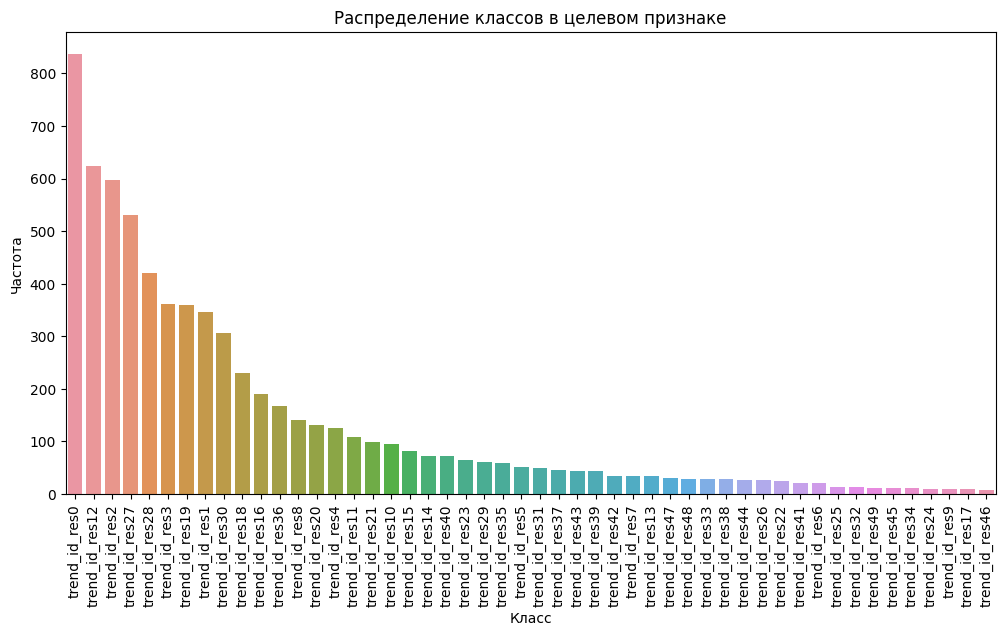

In [15]:
label_counts = train_data[target_columns].sum().sort_values(ascending=False)

# Распределение таргета
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Распределение классов в целевом признаке")
plt.xticks(rotation=90)
plt.xlabel("Класс")
plt.ylabel("Частота")
plt.show()

Проанализируем столбец text

Общая статистика по длине текста:
count    8708.000000
mean       72.666628
std        69.937462
min         1.000000
25%        19.000000
50%        48.000000
75%       102.000000
max       283.000000
Name: text_length, dtype: float64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


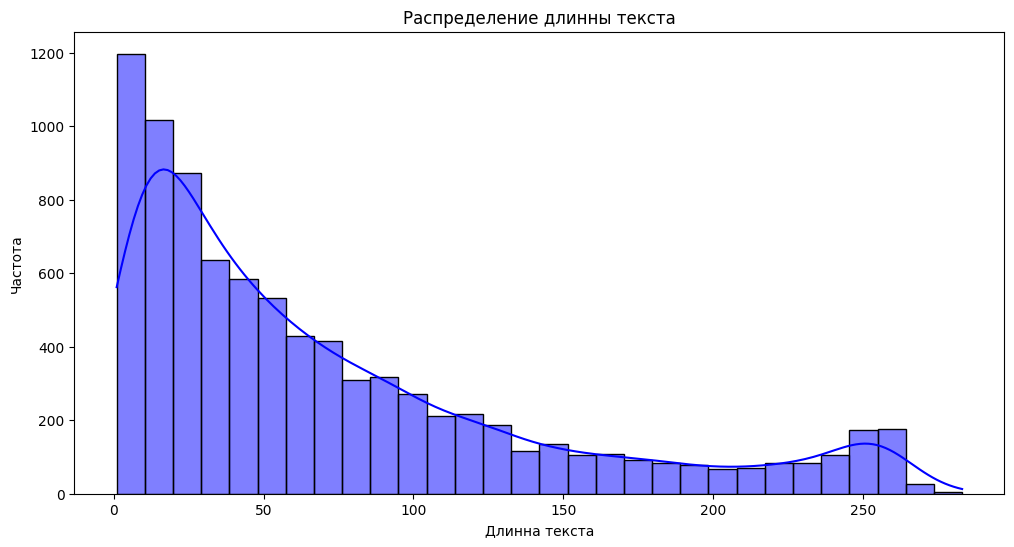

In [16]:
# Добавим новый столбец - длинна текста
train_data['text_length'] = train_data['text'].apply(len)
test_data['text_length'] = test_data['text'].apply(len)

# Статистика по длине текста
print("Общая статистика по длине текста:")
print(train_data['text_length'].describe())

# Распределения длины текстов
plt.figure(figsize=(12, 6))
sns.histplot(train_data['text_length'], bins=30, kde=True, color='blue')
plt.title("Распределение длинны текста")
plt.xlabel("Длинна текста")
plt.ylabel("Частота")
plt.show()

В среднем длинна текста около 73 символов, медиана - 48, минимум - 1, максимум - 283 символа.

In [17]:
# Проверка на дубликаты
duplicate_count = train_data.duplicated(subset=['text']).sum()
print(f"Количество тектовых дубликатов в train_data: {duplicate_count}")

Количество тектовых дубликатов в train_data: 1225


В течение анализа данных было выявлено наличие дисбаласна классов таргета: чаще всех встречается класс 0 - "Долгая доставка", 12 - "Высокие цены", 2 - "Время доставки не соответствует заявленому", что тесно связанно с 0 классом, реже всего класс 46 - "Время работы", 17 - "Не читаем комментарии", 9 - "Сумма заказа меняется во время набора корзины". Это может быть связанно со спецификой работы сервиса, т.к сервис является доставкой еды, большинство жалоб будут именно на процесс доставки и меньше на другие аспекты. Также были обнаружены текстовые дубликаты, что может быть объяснено тем, что люди коротко и один отвечают на опросы. Были сформулированы варианты работы с данными без целевого признака.

## Предобработка данных

Выделим эмодзи в отдельный признак для анализа, после очистки добавим эмодзи обратно в текст.

In [18]:
# Функция выделения эмодзи из текста
def extract_emojis(text):
    return ''.join(char for char in text if char in emoji.EMOJI_DATA)

train_data['emojis'] = train_data['text'].apply(extract_emojis)
test_data['emojis'] = test_data['text'].apply(extract_emojis)

print("\nПример выделенных эмодзи:")
print(train_data[['text', 'emojis']].head())


Пример выделенных эмодзи:
                                                                                 text  \
0  Маленький выбор товаров, хотелось бы ассортимент больше, а так вроде бы все хорошо   
1                                                                              Быстро   
2                                                    Доставка постоянно задерживается   
3                                                  Наценка и ассортимент расстраивают   
4                                                                   Доставка просто 👍   

  emojis  
0         
1         
2         
3         
4      👍  


Добавим к стобцу text теги из tegs, чтобы сохранить важную информацию.

In [19]:
train_data['combined_text'] = train_data['tags'] + " "+  train_data['text']
test_data['combined_text'] = test_data['tags'] + " "+  test_data['text']
train_data[['index', 'combined_text']].head()

,index,combined_text
0,5652,"{ASSORTMENT,PROMOTIONS,DELIVERY} Маленький выбор товаров, хотелось бы ассортимент больше, а так вроде бы все хорошо"
1,18092,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY} Быстро"
2,13845,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT} Доставка постоянно задерживается"
3,25060,"{PRICE,PROMOTIONS,ASSORTMENT} Наценка и ассортимент расстраивают"
4,15237,"{ASSORTMENT,PRODUCTS_QUALITY,PROMOTIONS,CATALOG_NAVIGATION} Доставка просто 👍"


Очистим текст от лишних символов, приведем текст к нижнему регистру, удалим стоп-слова.

In [20]:
# Функция очистки текста
def clean_text(text):
    #Учитываем наличие пропусков
    text = str(text) if text is not None else ''
    # Разедлим теги чтобы они не слиплись
    text = re.sub(r'\{([^}]*)\}', lambda m: ' '.join(m.group(1).split(',')), text)
    # Удаление специальных символов
    text = re.sub(r'[^а-яА-ЯёЁa-zA-Z0-9\s]', '', text)
    # Удаление чисел 
    text = re.sub(r'\d+', '', text)
    # Приведение к нижнему регистру
    text = text.lower()
    return text

train_data['cleaned_text'] = train_data['combined_text'].apply(clean_text)
test_data['cleaned_text'] = test_data['combined_text'].apply(clean_text)

print("\nПример очищенного текста:")
print(train_data[['combined_text', 'cleaned_text']].head())


Пример очищенного текста:
                                                                                                         combined_text  \
0  {ASSORTMENT,PROMOTIONS,DELIVERY} Маленький выбор товаров, хотелось бы ассортимент больше, а так вроде бы все хорошо   
1                                                                  {ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY} Быстро   
2                                      {DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT} Доставка постоянно задерживается   
3                                                     {PRICE,PROMOTIONS,ASSORTMENT} Наценка и ассортимент расстраивают   
4                                        {ASSORTMENT,PRODUCTS_QUALITY,PROMOTIONS,CATALOG_NAVIGATION} Доставка просто 👍   

                                                                                                      cleaned_text  
0  assortment promotions delivery маленький выбор товаров хотелось бы ассортимент больше а так вроде бы все хорошо  
1     

In [21]:
# Добавляем эмодзи обратно в текст
train_data['cleaned_text'] = train_data['cleaned_text'] + train_data['emojis']
test_data['cleaned_text'] = test_data['cleaned_text'] + test_data['emojis']

Разобъем текст на токены.

In [22]:
# Функция для токенизации текста
def tokenize_text(text):
    tokenizer = TreebankWordTokenizer()
    return tokenizer.tokenize(text)

train_data['tokens'] = train_data['cleaned_text'].apply(tokenize_text)
test_data['tokens'] = test_data['cleaned_text'].apply(tokenize_text)

print("\nПример токенов:")
print(train_data[['cleaned_text', 'tokens']].head())


Пример токенов:
                                                                                                      cleaned_text  \
0  assortment promotions delivery маленький выбор товаров хотелось бы ассортимент больше а так вроде бы все хорошо   
1                                                                 assortment price productsquality delivery быстро   
2                                    delivery promotions price assortment support доставка постоянно задерживается   
3                                                   price promotions assortment наценка и ассортимент расстраивают   
4                                        assortment productsquality promotions catalognavigation доставка просто 👍   

                                                                                                                             tokens  
0  [assortment, promotions, delivery, маленький, выбор, товаров, хотелось, бы, ассортимент, больше, а, так, вроде, бы, все, хорошо]  
1     

Лемматизируем токены, оставим теги не тронутыми т.к они все в изначальной форме плюс они на английском языке.

In [23]:
# Инициализация лемматизаторов
morph = pymorphy2.MorphAnalyzer()
# Функция для лемматизации
def lemmatize_token(token):
    # Проверка на русские символы
    if any('а' <= ch <= 'я' or 'А' <= ch <= 'Я' for ch in token):
        # Лемматизируем
        return morph.parse(token)[0].normal_form
    else:
        # Теги
        return token

def lemmatize_tokens(tokens):
    return [lemmatize_token(token) for token in tokens]

train_data['lemmatized_tokens'] = train_data['tokens'].apply(lemmatize_tokens)
test_data['lemmatized_tokens'] = test_data['tokens'].apply(lemmatize_tokens)

print("\nПример лемматизированных токенов:")
print(train_data[['tokens', 'lemmatized_tokens']].head())


Пример лемматизированных токенов:
                                                                                                                             tokens  \
0  [assortment, promotions, delivery, маленький, выбор, товаров, хотелось, бы, ассортимент, больше, а, так, вроде, бы, все, хорошо]   
1                                                                            [assortment, price, productsquality, delivery, быстро]   
2                                            [delivery, promotions, price, assortment, support, доставка, постоянно, задерживается]   
3                                                            [price, promotions, assortment, наценка, и, ассортимент, расстраивают]   
4                                                 [assortment, productsquality, promotions, catalognavigation, доставка, просто, 👍]   

                                                                                                                 lemmatized_tokens  
0  [assortment, promo

In [24]:
# Объединим обработанный текст в один
def tokens_to_string(tokens):
    return ' '.join(tokens)

train_data['processed_text'] = train_data['lemmatized_tokens'].apply(tokens_to_string)
test_data['processed_text'] = test_data['lemmatized_tokens'].apply(tokens_to_string)

print("\nПример финального текста:")
print(train_data[['text', 'processed_text']].head())


Пример финального текста:
                                                                                 text  \
0  Маленький выбор товаров, хотелось бы ассортимент больше, а так вроде бы все хорошо   
1                                                                              Быстро   
2                                                    Доставка постоянно задерживается   
3                                                  Наценка и ассортимент расстраивают   
4                                                                   Доставка просто 👍   

                                                                                                   processed_text  
0  assortment promotions delivery маленький выбор товар хотеться бы ассортимент большой а так вроде бы всё хорошо  
1                                                                assortment price productsquality delivery быстро  
2                                   delivery promotions price assortment support доставка 

На этом этапе были обработаны тексты, блыа проведена очистка, токенизация и лемматизация, также был добавлен дополнительный признак - эмодзи.

## Исследовательский анализ данных

In [25]:
train_data.head()

,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,...,trend_id_res47,trend_id_res48,trend_id_res49,text_length,emojis,combined_text,cleaned_text,tokens,lemmatized_tokens,processed_text
0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортимент больше, а так вроде бы все хорошо",0,0,0,0,0,0,...,0,0,0,82,,"{ASSORTMENT,PROMOTIONS,DELIVERY} Маленький выбор товаров, хотелось бы ассортимент больше, а так вроде бы все хорошо",assortment promotions delivery маленький выбор товаров хотелось бы ассортимент больше а так вроде бы все хорошо,"[assortment, promotions, delivery, маленький, выбор, товаров, хотелось, бы, ассортимент, больше, а, так, вроде, бы, все, хорошо]","[assortment, promotions, delivery, маленький, выбор, товар, хотеться, бы, ассортимент, большой, а, так, вроде, бы, всё, хорошо]",assortment promotions delivery маленький выбор товар хотеться бы ассортимент большой а так вроде бы всё хорошо
1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,0,...,0,0,0,6,,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY} Быстро",assortment price productsquality delivery быстро,"[assortment, price, productsquality, delivery, быстро]","[assortment, price, productsquality, delivery, быстро]",assortment price productsquality delivery быстро
2,13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,0,...,0,0,0,32,,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT} Доставка постоянно задерживается",delivery promotions price assortment support доставка постоянно задерживается,"[delivery, promotions, price, assortment, support, доставка, постоянно, задерживается]","[delivery, promotions, price, assortment, support, доставка, постоянно, задерживаться]",delivery promotions price assortment support доставка постоянно задерживаться
3,25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,0,0,...,0,0,0,34,,"{PRICE,PROMOTIONS,ASSORTMENT} Наценка и ассортимент расстраивают",price promotions assortment наценка и ассортимент расстраивают,"[price, promotions, assortment, наценка, и, ассортимент, расстраивают]","[price, promotions, assortment, наценка, и, ассортимент, расстраивать]",price promotions assortment наценка и ассортимент расстраивать
4,15237,5.0,"{ASSORTMENT,PRODUCTS_QUALITY,PROMOTIONS,CATALOG_NAVIGATION}",Доставка просто 👍,0,0,0,0,0,0,...,0,0,0,17,👍,"{ASSORTMENT,PRODUCTS_QUALITY,PROMOTIONS,CATALOG_NAVIGATION} Доставка просто 👍",assortment productsquality promotions catalognavigation доставка просто 👍,"[assortment, productsquality, promotions, catalognavigation, доставка, просто, 👍]","[assortment, productsquality, promotions, catalognavigation, доставка, просто, 👍]",assortment productsquality promotions catalognavigation доставка просто 👍


In [26]:
all_emojis = ''.join(train_data['emojis'].dropna())

# Подсчитываем частоту каждого эмодзи
emoji_counter = Counter(all_emojis)

# Самые популярные эмодзи
top_emojis = emoji_counter.most_common(10)

print("Топ 10 популярных эмодзи:")
for emoji_char, count in top_emojis:
    print(f"{emoji_char}: {count}")

Топ 10 популярных эмодзи:
👍: 174
🏻: 77
❤: 74
🔥: 33
👌: 28
🏼: 23
🙏: 19
👎: 16
🥰: 15
😊: 14


In [27]:
# Подсчитаем количество меток, привязанных к каждому отзыву
train_data['num_track'] = train_data[target_columns].sum(axis=1)
print("Статистика по количеству меток:")
print(train_data['num_track'].describe())

Статистика по количеству меток:
count    8708.000000
mean        0.775838
std         0.896149
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: num_track, dtype: float64


In [28]:
#Удалим ненужные столбцы из датафрейма
columns_to_drop = ['num_track', 'cleaned_text', 'tokens', 'lemmatized_tokens', 'assessment', 'tags', 'combined_text']
train_data = train_data.drop(columns=columns_to_drop, axis=1)
train_data = train_data.set_index("index")
test_data = test_data.set_index("index")

train_data.head()

,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,trend_id_res7,trend_id_res8,...,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49,text_length,emojis,processed_text
index,,,,,,,,,,,,,,,,,,,,,
5652,"Маленький выбор товаров, хотелось бы ассортимент больше, а так вроде бы все хорошо",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,82,,assortment promotions delivery маленький выбор товар хотеться бы ассортимент большой а так вроде бы всё хорошо
18092,Быстро,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6,,assortment price productsquality delivery быстро
13845,Доставка постоянно задерживается,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,32,,delivery promotions price assortment support доставка постоянно задерживаться
25060,Наценка и ассортимент расстраивают,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,34,,price promotions assortment наценка и ассортимент расстраивать
15237,Доставка просто 👍,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,17,👍,assortment productsquality promotions catalognavigation доставка просто 👍


На этом этапе были проанализиррованы самые популярные эмодзи, была приведена статистика по меткам и удалены ненужные столбцы из датафрейма

## Подбор модели и гиперпараметров

Подготовим данные

In [29]:
X = train_data["processed_text"].values
y = train_data[target_columns].values

In [30]:
# Разделение данных на тренировочную и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [31]:
#tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruRoberta-large")
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

# Созадем датасеты 
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        tokens = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            'input_ids': tokens['input_ids'].squeeze(0),
            'attention_mask': tokens['attention_mask'].squeeze(0),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

# Даталоадеры для эффективного обучения
train_dataset = TextDataset(X_train, y_train, tokenizer)
val_dataset = TextDataset(X_val, y_val, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Модель DeepPavlov/rubert-base-cased способна обрабатывать смешанные тексты, но с некоторыми ограничениями в части обработки английского языка. Если русский текст доминирует, модель выполнит задачу с приемлемым качеством.

In [32]:
# Строим архитектуру на основе преобученной модели
class MultiLabelClassifier(torch.nn.Module):
    def __init__(self, model_name, num_labels):
        super(MultiLabelClassifier, self).__init__()
        self.config = AutoConfig.from_pretrained(model_name, num_labels=num_labels)
        self.bert = AutoModel.from_pretrained(model_name, config=self.config)
        # Добавляем линейный классификатор
        self.classifier = torch.nn.Linear(self.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Выбираем скрытое состояние для CLS токена
        logits = self.classifier(outputs.last_hidden_state[:, 0, :])
        return logits

model = MultiLabelClassifier("DeepPavlov/rubert-base-cased", len(target_columns)).to("cuda")
#model = MultiLabelClassifier("sberbank-ai/ruRoberta-large", len(target_columns)).to("cuda")

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


В ходе работы были опробованы несколько преобученных моделей на русском языке, самыми лучшими стали DeepPavlov/rubert-base-cased и sberbank-ai/ruRoberta-large. В среднем моедль от команды DeepPavlov дает нужные нам метрики выше на 0.04.

Ниже приведен код, который использовался, чтобы улучшить нашу модель, но со своей задачей не справился.


Чтобы решить проблему дисбаланса классов, можно добавить веса, что должно помочь модели предскаывать редкие классы.

```
Вычисление весов для классов
def calculate_class_weights(labels):
    class_counts = labels.sum(dim=0)
    class_weights = 1.0 / (class_counts / class_counts.sum())
    return class_weights

all_labels = torch.cat([batch['labels'] for batch in train_loader], dim=0)
class_weights = calculate_class_weights(all_labels)
pos_weight = class_weights.to("cuda")
'''

Второй идеей для борьбы с дисбалансом стала улучшенная метрика, которая лучше учитывает дисбаланс - FocalLoss.

```
Функция потерь FocalLoss
classclass FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss) 
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

Далее осуществлялся подбор гиперпараметров для optimizer, FocalLoss.

```
Подбор гиперпараметров для моделей 
def objective(trial):
    learning_rate = trial.suggest_float("lr", 1e-6, 1e-4, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.1, 0.5)
    alpha = trial.suggest_float("alpha", 0.5, 2.0)
    gamma = trial.suggest_float("gamma", 1.0, 5.0)


    class MultiLabelClassifier(torch.nn.Module):
        def __init__(self, model_name, num_labels):
            super(MultiLabelClassifier, self).__init__()
            self.config = AutoConfig.from_pretrained(model_name)
            self.base_model = AutoModel.from_pretrained(model_name, config=self.config)
            for param in self.base_model.parameters():
                param.requires_grad = False
            
            self.classifier = torch.nn.Sequential(
                torch.nn.Linear(self.config.hidden_size, 256),
                torch.nn.ReLU(),
                torch.nn.Dropout(dropout_rate),  # Используем гиперпараметр dropout
                torch.nn.Linear(256, num_labels)
            )

        def forward(self, input_ids, attention_mask):
            with torch.no_grad():
                outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
            cls_output = outputs.last_hidden_state[:, 0, :]
            logits = self.classifier(cls_output)
            return logits


    model = MultiLabelClassifier("DeepPavlov/rubert-base-cased", len(target_columns)).to("cuda")
    optimizer = AdamW(model.classifier.parameters(), lr=learning_rate)
    

    criterion = FocalLoss(alpha=alpha, gamma=gamma)
    

    num_training_steps = len(train_loader) * 3 
    lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    def train_and_validate(model, train_loader, val_loader):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to("cuda")
            attention_mask = batch['attention_mask'].to("cuda")
            labels = batch['labels'].to("cuda")

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
        
        model.eval()
        val_loss = 0
        preds, true_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to("cuda")
                attention_mask = batch['attention_mask'].to("cuda")
                labels = batch['labels'].to("cuda")

                logits = model(input_ids, attention_mask)
                val_loss += criterion(logits, labels).item()

                preds.append((torch.sigmoid(logits) > 0.5).cpu().numpy())
                true_labels.append(labels.cpu().numpy())

        val_loss /= len(val_loader)
        preds = np.vstack(preds)
        true_labels = np.vstack(true_labels)
        accuracy = np.mean(np.all(preds == true_labels, axis=1))
        
        return val_loss, accuracy


    val_loss, accuracy = train_and_validate(model, train_loader, val_loader)
    

    return val_loss

```
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Лучшие гиперпараметры
print("Best trial:")
print(study.best_trial.params)

## Обучение модели и анализ ошибок

Для обучения нашей модели напишем функцию обучения и валидации, оптимизатором выберем AdamW так как он универсален, также для learning rate будем исполькзовать lr_scheduler чтобы постепенно изменять lr для эффективности нахождения минимума. В качестве функции потерь возьмем BCEWithLogitsLoss из-за ее простоты и производительности.

In [33]:
optimizer = AdamW(model.parameters(), lr=9e-5)
num_training_steps = len(train_loader) * 20
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
criterion = torch.nn.BCEWithLogitsLoss()
#criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
#criterion = FocalLoss(alpha=0.25, gamma=2.0)

# функция тренировки и валидации
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=20):
    train_losses = []
    val_losses = []
    accuracies = []
    best_accuracy = 0
    best_model_path = "best_model.pth"

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to("cuda")
            attention_mask = batch['attention_mask'].to("cuda")
            labels = batch['labels'].to("cuda")

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            
        train_losses.append(train_loss / len(train_loader))
        print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader):.4f}")

        # Валивадция
        model.eval()
        val_loss = 0
        preds, true_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to("cuda")
                attention_mask = batch['attention_mask'].to("cuda")
                labels = batch['labels'].to("cuda")

                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)
                val_loss += loss.item()

                preds.append((torch.sigmoid(logits) > 0.5).cpu().numpy())
                true_labels.append(labels.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        preds = np.vstack(preds)
        true_labels = np.vstack(true_labels)
        accuracy = np.mean(np.all(preds == true_labels, axis=1))
        accuracies.append(accuracy)
        print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {accuracy:.4f}")


        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved at epoch {epoch+1} with accuracy {best_accuracy:.4f}")
            
    # Графифки loss и acuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return preds, true_labels

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Train Loss: 0.0831
Validation Loss: 0.0560, Accuracy: 0.4604
Best model saved at epoch 1 with accuracy 0.4604
Epoch 2, Train Loss: 0.0487
Validation Loss: 0.0473, Accuracy: 0.5098
Best model saved at epoch 2 with accuracy 0.5098
Epoch 3, Train Loss: 0.0409
Validation Loss: 0.0445, Accuracy: 0.4977
Epoch 4, Train Loss: 0.0352
Validation Loss: 0.0413, Accuracy: 0.5310
Best model saved at epoch 4 with accuracy 0.5310
Epoch 5, Train Loss: 0.0297
Validation Loss: 0.0416, Accuracy: 0.5212
Epoch 6, Train Loss: 0.0253
Validation Loss: 0.0419, Accuracy: 0.5373
Best model saved at epoch 6 with accuracy 0.5373
Epoch 7, Train Loss: 0.0213
Validation Loss: 0.0448, Accuracy: 0.5293
Epoch 8, Train Loss: 0.0174
Validation Loss: 0.0468, Accuracy: 0.5052
Epoch 9, Train Loss: 0.0140
Validation Loss: 0.0472, Accuracy: 0.5350
Epoch 10, Train Loss: 0.0113
Validation Loss: 0.0518, Accuracy: 0.5316
Epoch 11, Train Loss: 0.0090
Validation Loss: 0.0527, Accuracy: 0.5195
Epoch 12, Train Loss: 0.0071
Val

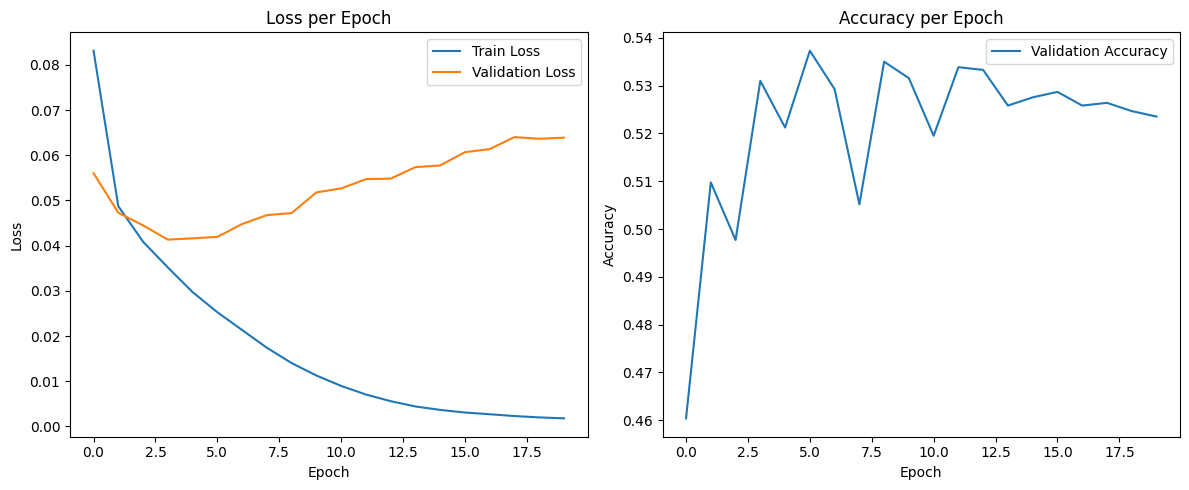

In [34]:
preds, true_labels = train_model(model, train_loader, val_loader, optimizer, lr_scheduler, criterion)

Проведем анализ ошибок, выведем хужшие классы и общую статистику по всем в виде графика F1-score, также приведем пример данных где модель ошибается

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


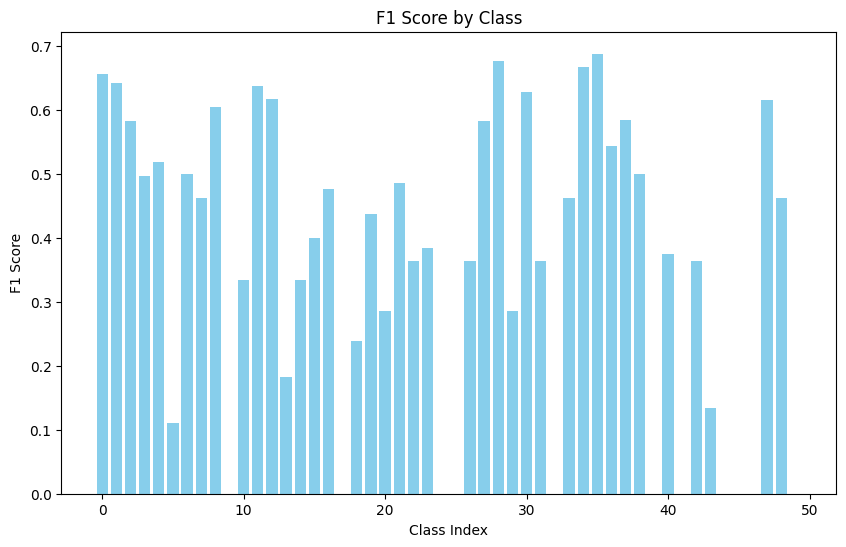

Худшие классы:
Класс trend_id_res9: F1 Score = 0.00, Precision = 0.00, Recall = 0.00
Класс trend_id_res25: F1 Score = 0.00, Precision = 0.00, Recall = 0.00
Класс trend_id_res24: F1 Score = 0.00, Precision = 0.00, Recall = 0.00
Класс trend_id_res17: F1 Score = 0.00, Precision = 0.00, Recall = 0.00
Класс trend_id_res41: F1 Score = 0.00, Precision = 0.00, Recall = 0.00


In [35]:
# Анализ ошибок
class_metrics = precision_recall_fscore_support(true_labels, preds, average=None)
precision, recall, f1_score, _ = class_metrics

# Построение графика F1-score для каждого класса
plt.figure(figsize=(10, 6))
plt.bar(range(len(target_columns)), f1_score, color='skyblue')
plt.xlabel('Class Index')
plt.ylabel('F1 Score')
plt.title('F1 Score by Class')
plt.show()

# Анализ самых сложных классов
worst_classes = np.argsort(f1_score)[:5]
print("Худшие классы:")
for idx in worst_classes:
    print(f"Класс {target_columns[idx]}: F1 Score = {f1_score[idx]:.2f}, Precision = {precision[idx]:.2f}, Recall = {recall[idx]:.2f}")


In [36]:
def show_model_errors_from_loader(preds, true_labels, dataset, threshold=0.5):

    binarized_preds = (torch.sigmoid(torch.tensor(preds)) > threshold).int()

    # Сохраняем индексы и классы ошибок
    error_details = []
    for i in range(len(true_labels)):
        true = torch.tensor(true_labels[i])
        pred = binarized_preds[i]
        if not torch.equal(pred, true):
            # Находим индексы классов, которые были прдсказаны неправильно
            incorrect_classes = (pred != true).nonzero(as_tuple=True)[0].tolist()
            error_details.append({
                "index": i,  # Индекс в датасете
                "incorrect_classes": incorrect_classes,  # Неправильные классы
            })
            if len(error_details) >= 5:  # Ограничим вывод количества ошибок - 5
                break


    print(f"Найдено {len(error_details)} ошибок из {len(true_labels)} примеров.")
    for error in error_details:
        print(f"Индекс: {error['index']}, Неправильные классы: {error['incorrect_classes']}")
    
show_model_errors_from_loader(preds, true_labels, val_dataset)

Найдено 5 ошибок из 1742 примеров.
Индекс: 2, Неправильные классы: [19, 21]
Индекс: 5, Неправильные классы: [27]
Индекс: 6, Неправильные классы: [30]
Индекс: 7, Неправильные классы: [0, 35]
Индекс: 10, Неправильные классы: [14]


In [37]:
train_data.iloc[2]

text                                                           Доставка постоянно задерживается
trend_id_res0                                                                                 0
trend_id_res1                                                                                 0
trend_id_res2                                                                                 0
trend_id_res3                                                                                 1
trend_id_res4                                                                                 0
trend_id_res5                                                                                 0
trend_id_res6                                                                                 0
trend_id_res7                                                                                 0
trend_id_res8                                                                                 0
trend_id_res9                           

## Предсказание на тестовых данных

In [38]:
def predict_from_cleaned_dataframe_with_index(
    model_path, test_data, tokenizer, max_length=128, threshold=0.5, device="cuda"):

    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)
    
    # Список для хранения предсказаний
    all_predictions = []
    
    with torch.no_grad():
        for text in test_data["processed_text"]:
            # Токенизация текста
            tokens = tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )
            input_ids = tokens["input_ids"].to(device)
            attention_mask = tokens["attention_mask"].to(device)
            
            # Получение предсказаний
            logits = model(input_ids=input_ids, attention_mask=attention_mask)  # Возвращаем тензор логитов
            probabilities = torch.sigmoid(logits).cpu()
            binarized_preds = (probabilities > threshold).int()
            
            all_predictions.append(binarized_preds.squeeze(0).tolist())
    
    # DataFrame с результатами
    columns = [f"trend_id_res{i}" for i in range(len(all_predictions[0]))]
    predictions_df = pd.DataFrame(all_predictions, columns=columns, index=test_data.index)
    
    return predictions_df



model_path = "best_model.pth"  # Укажите путь к лучшей модели
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

predictions_df = predict_from_cleaned_dataframe_with_index(
    model_path=model_path,
    test_data=test_data,
    tokenizer=tokenizer
)

# Сохранение предсказаний в CSV
predictions_df.to_csv("test_predictions.csv")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<ipython-input-38-7e0f5d7bfba9>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unles

## Заключение

В ходе работы над данным проектом решалась задача создания NLP модели для предсказания тематик, которые затрагиваются в пользовательском ответе на опросы.

Сначала изучалась теория необходимая для решения задач NLP, как решаются такие задачи, примеры архитектур и самых популярных моделей для этих задач. Вместе с этим проводился первичный анализ данных: данные были загружены и просмотрены. Была произведена проверка на пропуски в данных и обнаружено, что почти половина данных не имеет целевого признака. В связи с этим были выдвинуты 3 варианта действий: 
1. Оставляем все данные как есть и учим модель предсказывать остутсвие калссов.
2. Удаляем все данные без таргета, и акцентируем внимание модели на предсказание классов.
3. Оставляем часть таких данных (около 150 - среднее количество данных на класс), а остальное удаляем.

В теории лучшим вариантом должен быть 3 но на практике лучшую метрику дает 1, так как почти в валидационном датасете остается достаточное количество данных с нулевыми таргетами, а наша модель научилась неплохо их предсказывать. Если в тестовом датасете, также есть такие данные, то модель проявит себя неплохо.

Далее проводилась преобработка данных: блыа проведена очистка, токенизация и лемматизация, также был выделен дополнительный признак - эмодзи.
Следующим шагом стал исследовательский анализ, в котором были проанализиррованы самые популярные эмодзи, была приведена статистика по меткам и и удалены ненужные столбцы из датафрейма.

В ходе подбора модели и её гиперпараметров были опробованы различные предобученые модели из них выделялась лучшим образом rubert от команды DeepPavlov. На ней было решено остановиться. На этом этапе было опробовано много различных способов как улучшить нашу модель, такие как добавление весов или выбор другого лосса. В конечном счете лучшей моделью стала предобученая DeepPavlov/rubert-base-cased с линейным классификатором, оптисизатором Adamw, lr=9e-5 и функцией потерь BCEWithLogitsLoss. На валидационной выборке модель показывает accuracy = 0.54. Далее проводился анализ ошибок: самыми сложными для предсказания классами стали 5, 6, 7, 9, 10. Также был приведен пример, в котором модель допустила ошибки.